In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Forecasting by SARIMAX

In [ ]:
import warnings
warnings.filterwarnings('ignore')



In [7]:
from datetime import datetime
import requests
from io import BytesIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


air2 = requests.get('http://www.stata-press.com/data/r12/air2.dta').content
air_df = pd.read_stata(BytesIO(air2))


air_df['month'] = pd.date_range(start=datetime(air_df.time[0], 1, 1), periods=len(air_df), freq='MS')
air_df['lnair'] = np.log(air_df['air'])

air_df.head()

,air,time,t,month,lnair
0,112,1949.000000,1.0,1949-01-01,4.718499
1,118,1949.083374,2.0,1949-02-01,4.770685
2,132,1949.166626,3.0,1949-03-01,4.882802
3,129,1949.250000,4.0,1949-04-01,4.859812
4,121,1949.333374,5.0,1949-05-01,4.795791


In [10]:
data = air_df[['month','air']]

data.columns = ['month','passengers']
data['month'] = pd.to_datetime(data['month'],format='%Y-%m')
data = data.set_index('month')
data.head()

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


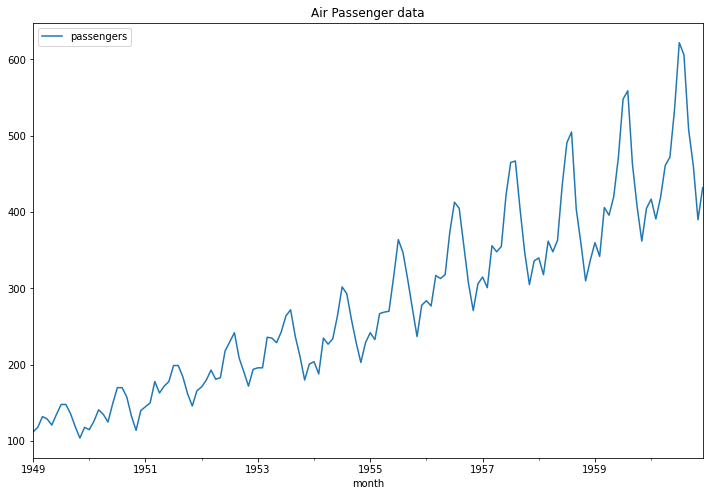

In [11]:
data.plot(figsize=(12,8))
plt.title("Air Passenger data")
plt.show()

In [43]:
## Missing value imputation
data['passengers_cubic_imputation'] = data.passengers.interpolate(method='cubic')

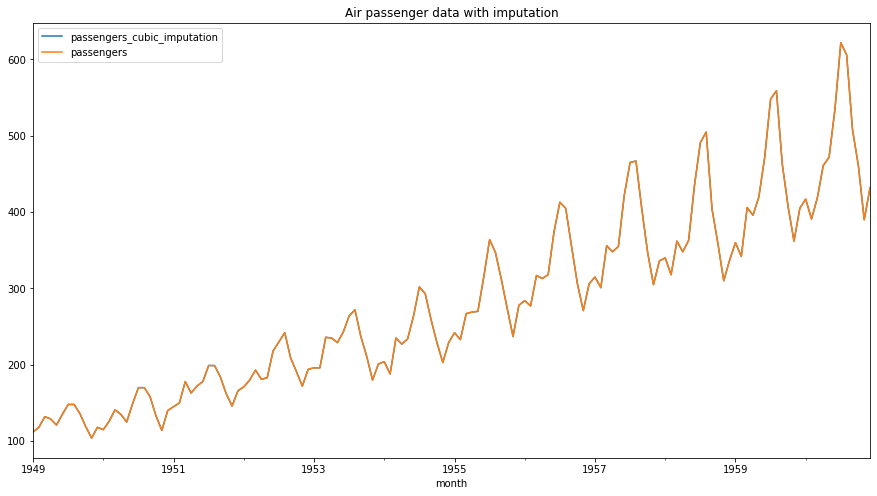

In [44]:
data[['passengers_cubic_imputation','passengers']].plot(figsize=(15,8))
plt.title("Air passenger data with imputation")
plt.legend(loc='best')
plt.show(block=False)
plt.show()

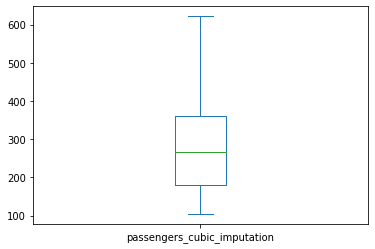

In [14]:
data['passengers_cubic_imputation'].plot(kind='box')
plt.show()

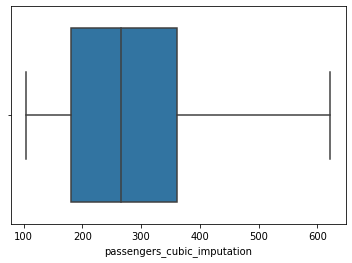

In [15]:
sns.boxplot(data['passengers_cubic_imputation'])
plt.show()

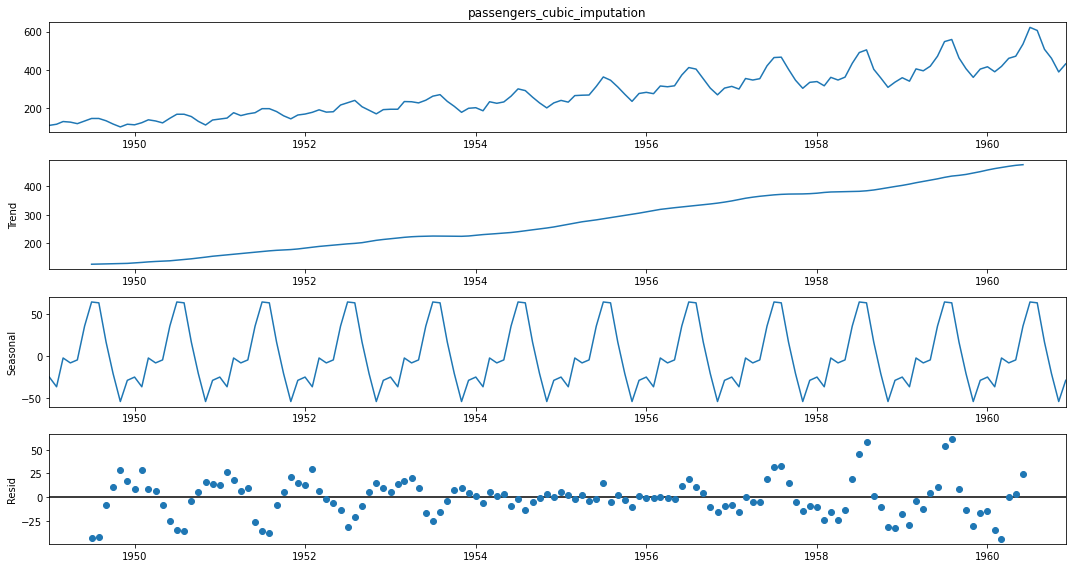

In [16]:
from pylab import rcParams
rcParams['figure.figsize']= 15,8
decompose = sm.tsa.seasonal_decompose(data.passengers_cubic_imputation,model='additive')
decompose.plot()
plt.show()

In [17]:
data.head()

,passengers,passengers_cubic_imputation
month,,
1949-01-01,112,112
1949-02-01,118,118
1949-03-01,132,132
1949-04-01,129,129
1949-05-01,121,121


In [18]:
data['passengers_diff'] = data['passengers_cubic_imputation'].diff()

data.head()

,passengers,passengers_cubic_imputation,passengers_diff
month,,,
1949-01-01,112,112,NaN
1949-02-01,118,118,6.0
1949-03-01,132,132,14.0
1949-04-01,129,129,-3.0
1949-05-01,121,121,-8.0


In [19]:
from statsmodels.tsa.stattools import adfuller

test_result = adfuller(data['passengers_cubic_imputation'].dropna(), autolag='AIC')
print("Passenger data ADfuller test")
print('Test statistic = {:.3f}'.format(test_result[0]))
print('Test p-value = {:.3f}'.format(test_result[1]))
print('Critical value at 5% = {:.3f}'.format(test_result[4]['5%']))

Passenger data ADfuller test
Test statistic = 0.815
Test p-value = 0.992
Critical value at 5% = -2.884


**Above we can see that test statistic is much higher than critical value and also p-value is greater than 0.5, we can conclude the series is non-stationary**

In [20]:
test_result = adfuller(data['passengers_diff'].dropna(), autolag='AIC')
print("Passenger data ADfuller test after ist order difference")
print('Test statistic = {:.3f}'.format(test_result[0]))
print('Test p-value = {:.3f}'.format(test_result[1]))
print('Critical value at 5% = {:.3f}'.format(test_result[4]['5%']))

Passenger data ADfuller test after ist order difference
Test statistic = -2.829
Test p-value = 0.054
Critical value at 5% = -2.884


**After 1st order of difference we can see that series is non stationary in nature**

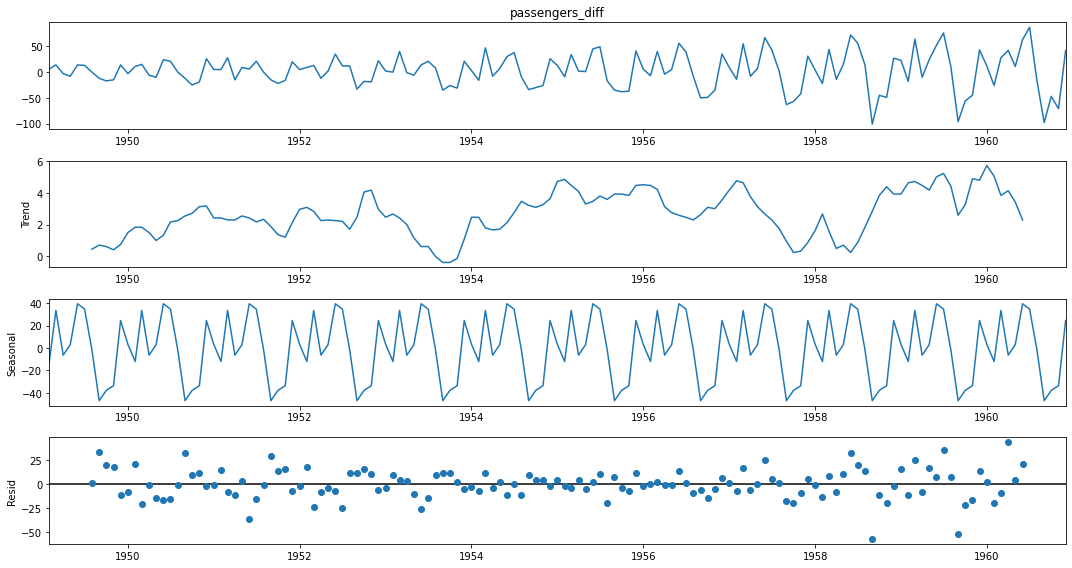

In [21]:
## Ploting seasonal decompose of difference series
decompose = sm.tsa.seasonal_decompose(data['passengers_diff'].dropna(), model='Additive')
decompose.plot()
plt.show()

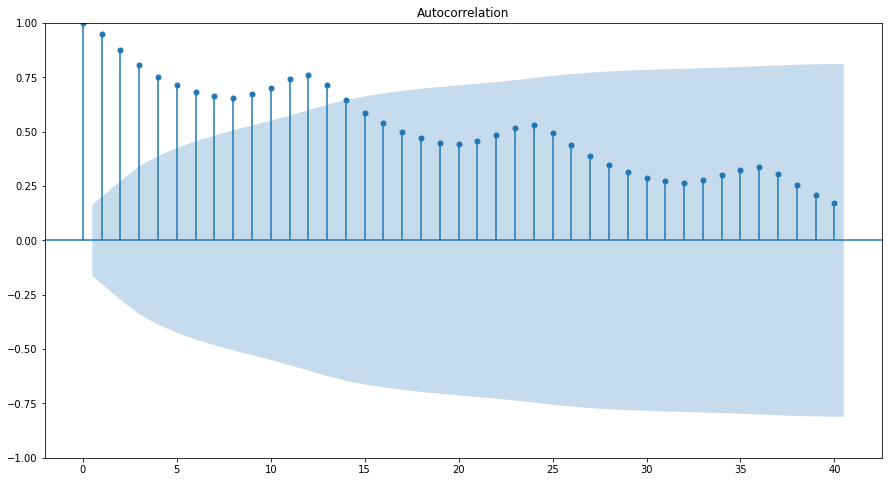

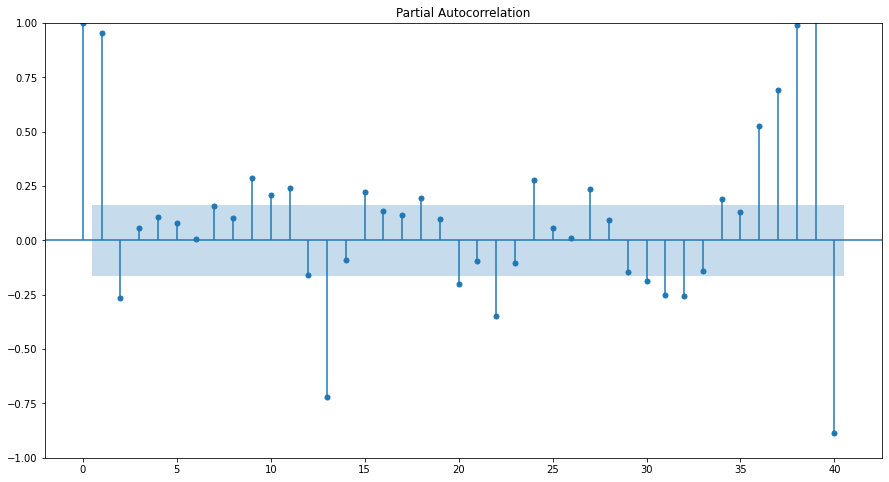

In [22]:
## Let us confirm by ACF and PACF plot

fig = sm.graphics.tsa.plot_acf(data['passengers_cubic_imputation'], lags=40)
fig = sm.graphics.tsa.plot_pacf(data['passengers_cubic_imputation'], lags=40)

**Above ACF plot decays gradually, and pacf plot also goes to negative at lag1 which shows differenceing of 1, however if we closly see we can see negative spikes in 12 lags**

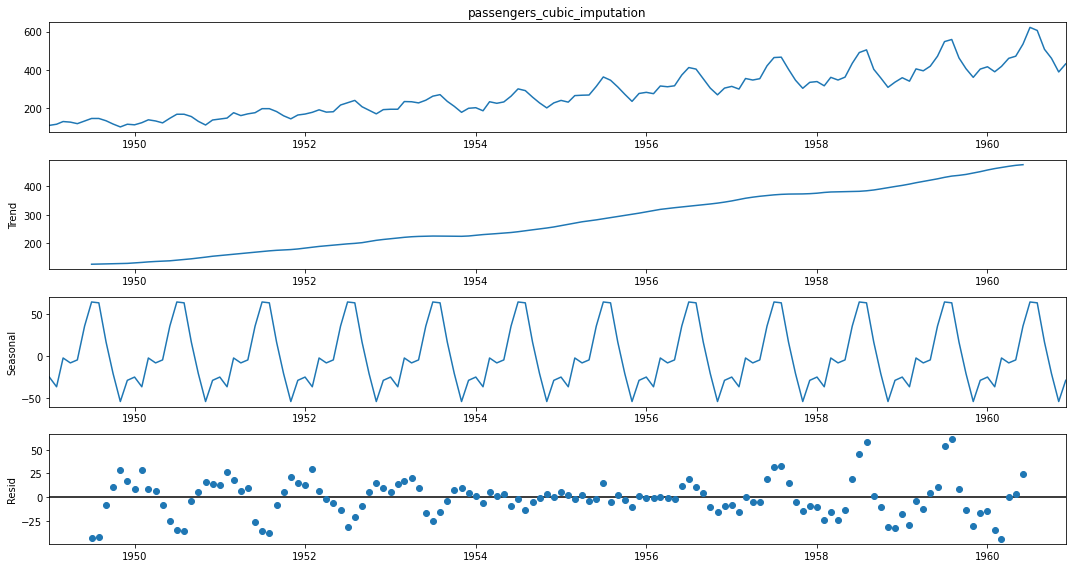

In [23]:
decompose = sm.tsa.seasonal_decompose(data['passengers_cubic_imputation'], model='Additive',period=12)
decompose.plot()
plt.show()

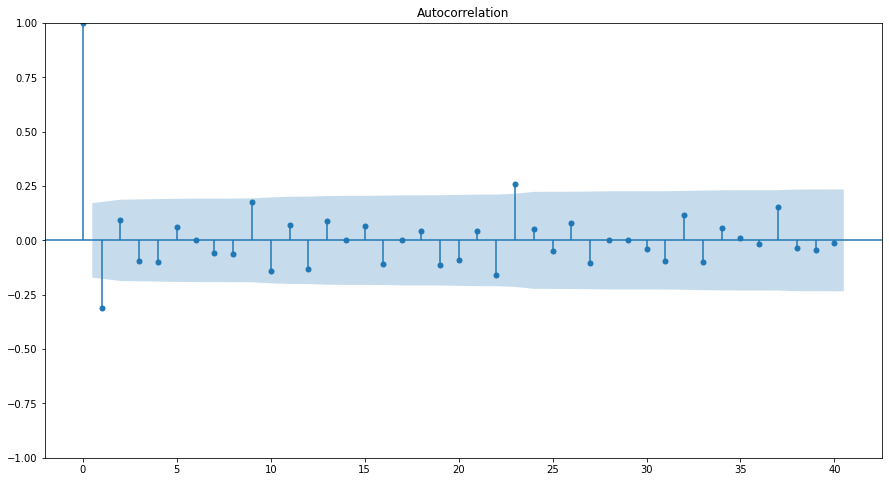

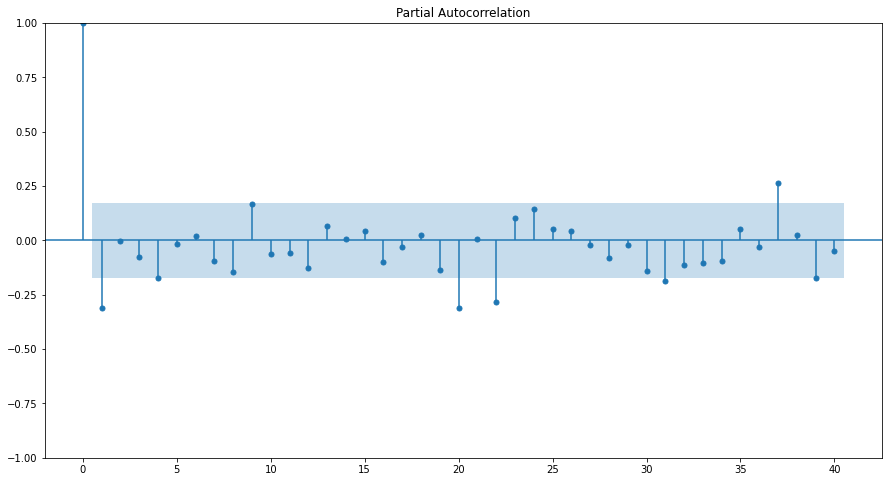

In [24]:
fig = sm.graphics.tsa.plot_acf(data['passengers_diff'].diff(12).dropna(), lags=40)
fig = sm.graphics.tsa.plot_pacf(data['passengers_diff'].diff(12).dropna(), lags=40)

In [25]:
test_result = adfuller(data['passengers_diff'].diff().dropna(), autolag='AIC')
print("Passenger data ADfuller test after ist order difference")
print('Test statistic = {:.3f}'.format(test_result[0]))
print('Test p-value = {:.3f}'.format(test_result[1]))
print('Critical value at 5% = {:.3f}'.format(test_result[4]['5%']))

Passenger data ADfuller test after ist order difference
Test statistic = -16.384
Test p-value = 0.000
Critical value at 5% = -2.884


In [50]:
model = sm.tsa.statespace.SARIMAX(data['passengers_cubic_imputation'],order=(1,2,1))
res = model.fit(disp=False)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:     passengers_cubic_imputation   No. Observations:                  144
Model:                        SARIMAX(1, 2, 1)   Log Likelihood                -696.464
Date:                         Thu, 19 May 2022   AIC                           1398.928
Time:                                 06:14:06   BIC                           1407.796
Sample:                             01-01-1949   HQIC                          1402.532
                                  - 12-01-1960                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3130      0.100      3.127      0.002       0.117       0.509
ma.L1         -0.9998      6.171     -0.162      0.871     -13.094      11.094
sigma2      1034.0211   6419.614      0.161      0.872   -1.15e+04    1.36e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.56   Jarque-Bera (JB):                 4.93
Prob(Q):                              0.45   Prob(JB):                         0.09
Heteroskedasticity (H):               8.37   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

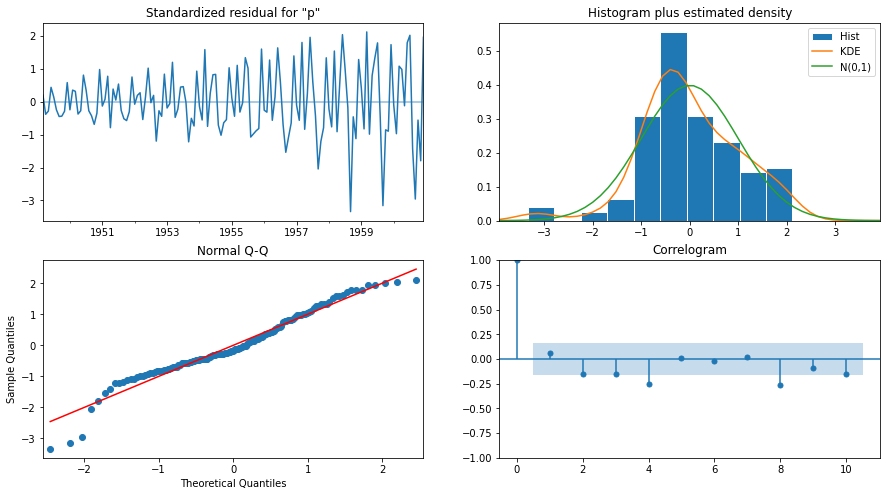

In [51]:
res.plot_diagnostics()
plt.show()

In [48]:
# model2 = sm.tsa.statespace.SARIMAX(data['passengers_cubic_imputation'],order=(3,1,3),seasonal_order=(1,1,0,12), simple_differencing=True)
# res2 = model2.fit(disp=False)
# res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:     D.DS12.passengers_cubic_imputation   No. Observations:                  131
Model:                SARIMAX(3, 0, 3)x(1, 0, [], 12)   Log Likelihood                -499.008
Date:                                Thu, 19 May 2022   AIC                           1014.016
Time:                                        06:13:51   BIC                           1037.017
Sample:                                    02-01-1950   HQIC                          1023.362
                                         - 12-01-1960                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1938      0.093     -2.075      0.038      -0.377      -0.011
ar.L2         -0.1424      0.103     -1.386      0.166      -0.344       0.059
ar.L3          0.7398      0.096      7.685      0.000       0.551       0.929
ma.L1         -0.0915      0.053     -1.727      0.084      -0.195       0.012
ma.L2          0.1091      0.066      1.652      0.098      -0.020       0.238
ma.L3         -0.9553      0.081    -11.750      0.000      -1.115      -0.796
ar.S.L12      -0.1912      0.113     -1.695      0.090      -0.412       0.030
sigma2       117.6954     16.290      7.225      0.000      85.767     149.624
===================================================================================
Ljung-Box (L1) (Q):                   0.50   Jarque-Bera (JB):                 8.75
Prob(Q):                              0.48   Prob(JB):                         0.01
Heteroskedasticity (H):               2.23   Skew:                             0.11
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
# res2.plot_diagnostics()
# plt.show()

ValueError: Length of values (131) does not match length of index (144)

<Figure size 1080x576 with 0 Axes>

In [52]:
prediction = res.get_prediction(start=0,end=144).predicted_mean

prediction

1949-01-01      0.000000
1949-02-01    168.013790
1949-03-01    124.052928
1949-04-01    143.283969
1949-05-01    131.313997
                 ...    
1960-09-01    603.396861
1960-10-01    479.056697
1960-11-01    447.890623
1960-12-01    368.974343
1961-01-01    446.777323
Freq: MS, Name: predicted_mean, Length: 145, dtype: float64

In [53]:
data['prediction'] = prediction

data.tail()

,passengers,passengers_cubic_imputation,passengers_diff,prediction
month,,,,
1960-08-01,606,606,-16.0,651.960731
1960-09-01,508,508,-98.0,603.396861
1960-10-01,461,461,-47.0,479.056697
1960-11-01,390,390,-71.0,447.890623
1960-12-01,432,432,42.0,368.974343


In [54]:
def mape(y_true,y_pred):
    y_true,y_pred = np.array(y_true), np.array(y_pred)
    return np.round(np.mean((np.abs(y_true-y_pred)/y_true))*100,2)

mape(data['passengers_cubic_imputation'],data['prediction'])

9.82

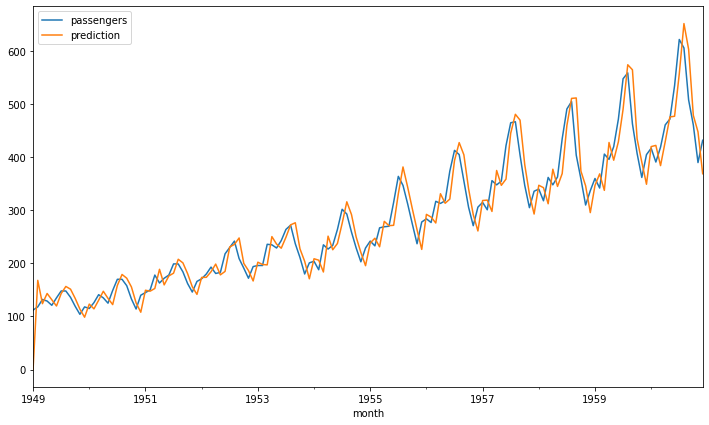

In [55]:
data[['passengers','prediction']].plot(figsize=(12,7))
plt.show()

In [56]:
est_order = smt.arma_order_select_ic(data['passengers_cubic_imputation'],ic='aic',trend='c')

In [57]:
est_order

{'aic':              0            1            2
 0  1790.367581  1618.862527  1522.126144
 1  1428.180531  1409.748723  1411.051018
 2  1413.638801  1408.249787  1408.343560
 3  1410.342984  1408.287772  1410.132564
 4  1409.759423  1409.466857  1394.162720,
 'aic_min_order': (4, 2)}

# Airline using log

In [58]:
from datetime import datetime
import requests
from io import BytesIO


air2 = requests.get('http://www.stata-press.com/data/r12/air2.dta').content
air_df = pd.read_stata(BytesIO(air2))
air_df.index = pd.date_range(start=datetime(air_df.time[0], 1, 1), periods=len(air_df), freq='MS')
air_df['lnair'] = np.log(air_df['air'])



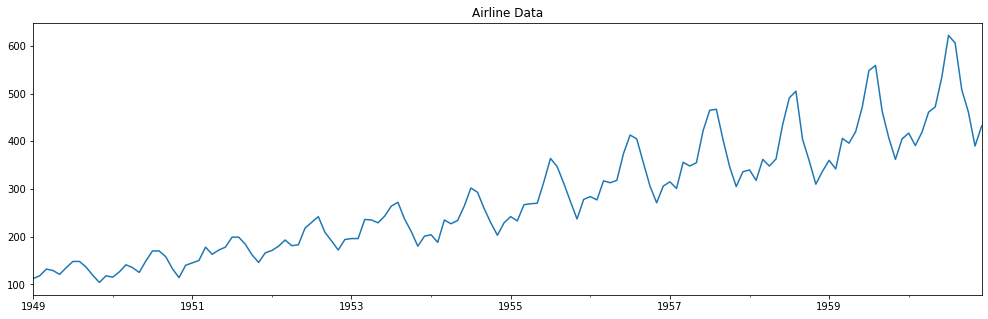

In [59]:
air_df['air'].plot(figsize=(17,5))
plt.title('Airline Data')
plt.show()

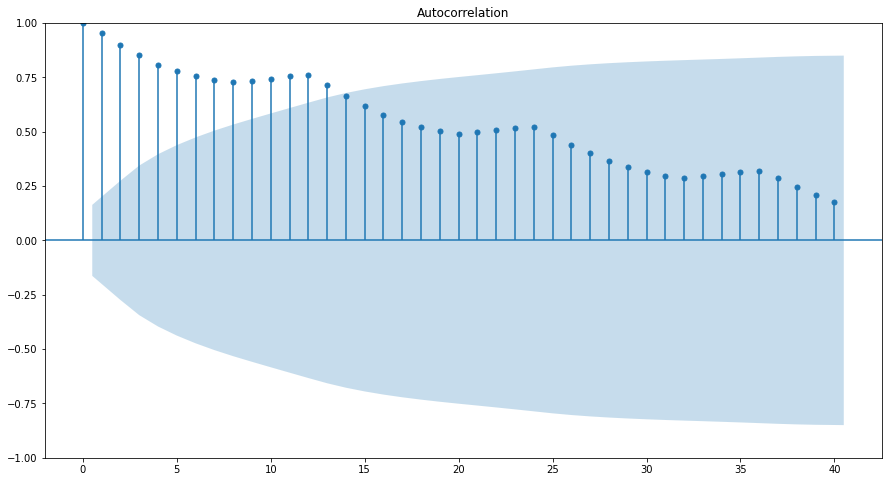

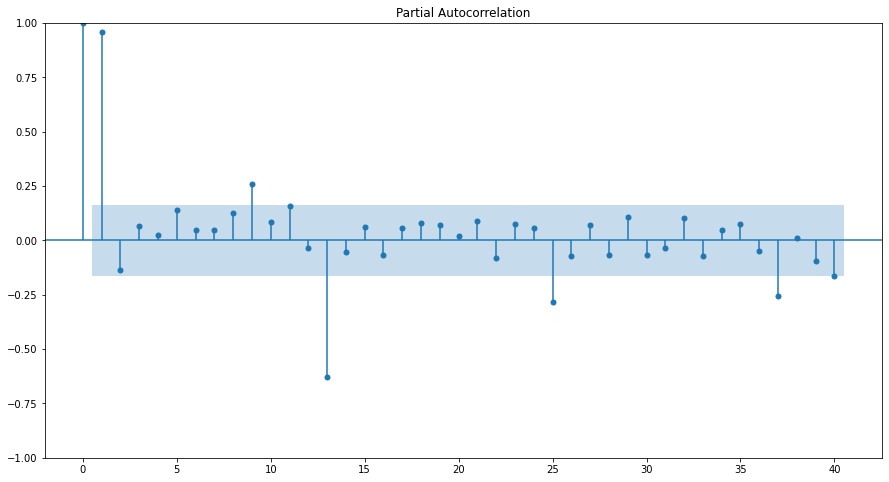

In [60]:
fig = sm.graphics.tsa.plot_acf(air_df['lnair'],lags=40)
fig = sm.graphics.tsa.plot_pacf(air_df['lnair'],lags=40)

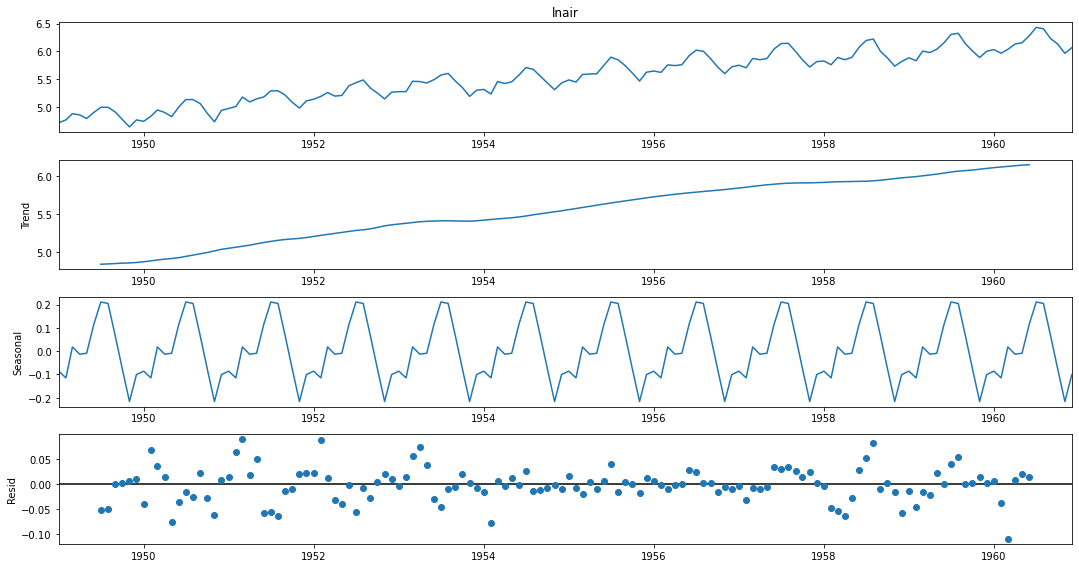

In [61]:
decompose = sm.tsa.seasonal_decompose(air_df.lnair,model='Additive')
decompose.plot()
plt.show()

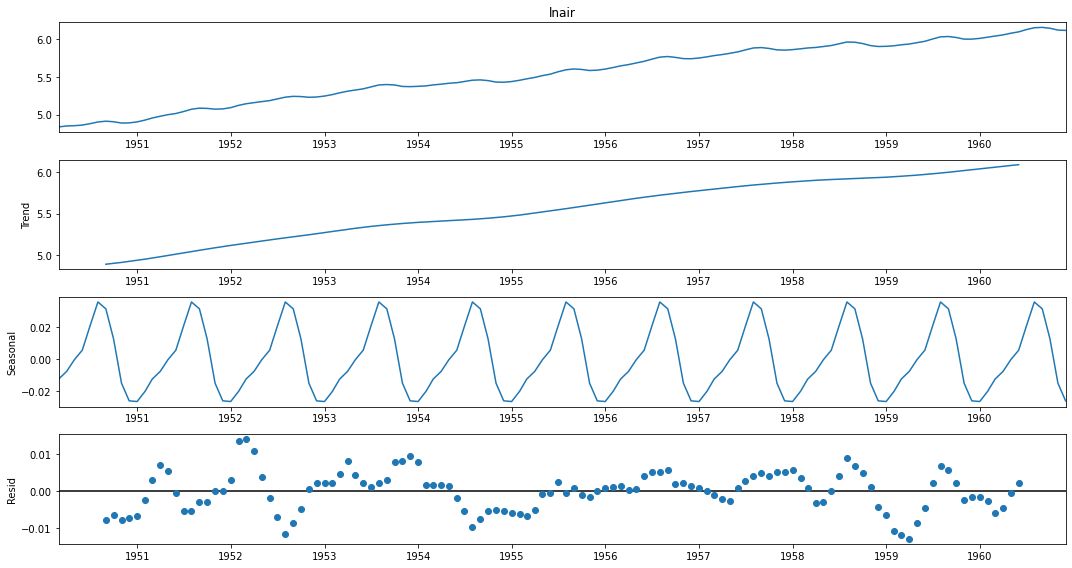

In [62]:
decompose = sm.tsa.seasonal_decompose(air_df.lnair.rolling(window=15).mean().dropna(),model='Additive')
decompose.plot()
plt.show()

In [63]:
est_order = smt.arma_order_select_ic(air_df.lnair,ic='aic',trend='c')
est_order

{'aic':             0           1           2
 0  176.160139    6.876217  -90.158352
 1 -228.130956 -235.407802 -236.295488
 2 -233.282791 -238.673159 -236.989231
 3 -234.409563 -236.868137 -243.187882
 4 -233.193559 -235.108490 -246.717129,
 'aic_min_order': (4, 2)}

In [64]:
## Model deployment

log_model = sm.tsa.statespace.SARIMAX(air_df.lnair,order=(3,1,0),seasonal_order=(1,1,0,12))
res_log = log_model.fit(disp=False)

res_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              lnair   No. Observations:                  144
Model:             SARIMAX(3, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 241.858
Date:                            Thu, 19 May 2022   AIC                           -473.715
Time:                                    06:17:15   BIC                           -459.339
Sample:                                01-01-1949   HQIC                          -467.874
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4129      0.083     -4.989      0.000      -0.575      -0.251
ar.L2         -0.1292      0.103     -1.253      0.210      -0.331       0.073
ar.L3         -0.1261      0.092     -1.364      0.172      -0.307       0.055
ar.S.L12      -0.4575      0.079     -5.791      0.000      -0.612      -0.303
sigma2         0.0014      0.000      8.444      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 0.35
Prob(Q):                              0.81   Prob(JB):                         0.84
Heteroskedasticity (H):               0.59   Skew:                             0.06
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

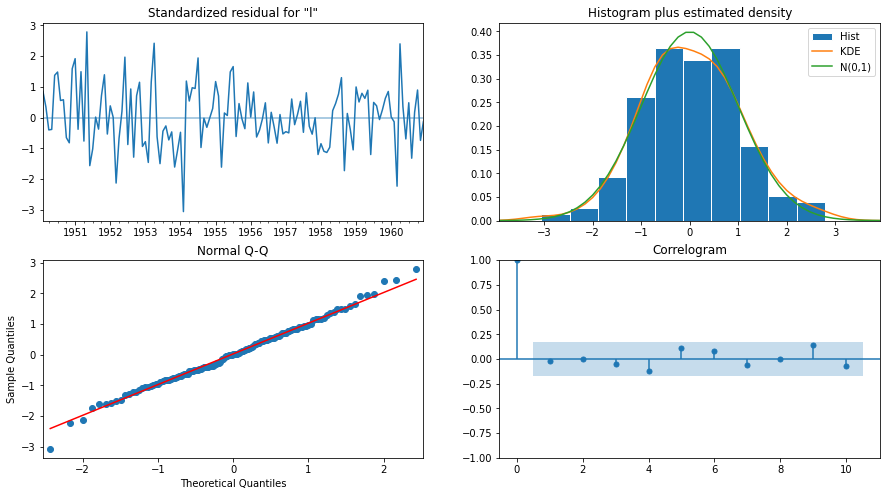

In [65]:
res_log.plot_diagnostics()
plt.show()

In [66]:
## Predicting future
log_rediction = res_log.get_prediction(start=0,end=144)
air_df['prediction'] = log_rediction.predicted_mean

In [67]:
## Conversion of log to normal
air_df['prediction'] = np.exp(air_df['prediction'])
air_df.head()

,air,time,t,lnair,prediction
1949-01-01,112,1949.000000,1.0,4.718499,1.000000
1949-02-01,118,1949.083374,2.0,4.770685,111.999981
1949-03-01,132,1949.166626,3.0,4.882802,118.000011
1949-04-01,129,1949.250000,4.0,4.859812,132.000011
1949-05-01,121,1949.333374,5.0,4.795791,128.999981


In [68]:
mape(air_df['air'],air_df['prediction'])

10.95

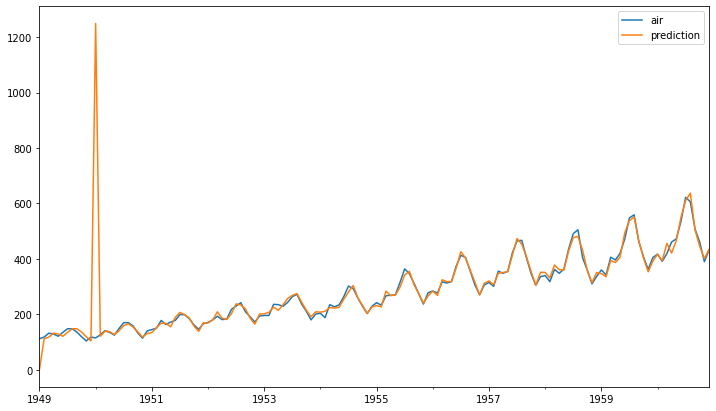

In [69]:
air_df[['air','prediction']].plot(figsize=(12,7))
plt.show()

In [70]:
#Resampling data to 
air_df['air'].resample('Q').sum()

1949-03-31     362
1949-06-30     385
1949-09-30     432
1949-12-31     341
1950-03-31     382
1950-06-30     409
1950-09-30     498
1950-12-31     387
1951-03-31     473
1951-06-30     513
1951-09-30     582
1951-12-31     474
1952-03-31     544
1952-06-30     582
1952-09-30     681
1952-12-31     557
1953-03-31     628
1953-06-30     707
1953-09-30     773
1953-12-31     592
1954-03-31     627
1954-06-30     725
1954-09-30     854
1954-12-31     661
1955-03-31     742
1955-06-30     854
1955-09-30    1023
1955-12-31     789
1956-03-31     878
1956-06-30    1005
1956-09-30    1173
1956-12-31     883
1957-03-31     972
1957-06-30    1125
1957-09-30    1336
1957-12-31     988
1958-03-31    1020
1958-06-30    1146
1958-09-30    1400
1958-12-31    1006
1959-03-31    1108
1959-06-30    1288
1959-09-30    1570
1959-12-31    1174
1960-03-31    1227
1960-06-30    1468
1960-09-30    1736
1960-12-31    1283
Freq: Q-DEC, Name: air, dtype: int16

# Forecasting by Statsmodel GAM (GLM)

https://www.statsmodels.org/dev/gam.html <br>
https://gist.github.com/josef-pkt/453de603b019143e831fbdd4dfb6aa30 <br>

In [10]:
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines,CyclicCubicSplines
from statsmodels.gam.generalized_additive_model import LogitGam
from statsmodels.gam.tests.test_penalized import df_autos

## Data Import

In [11]:
from datetime import datetime
import requests
from io import BytesIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


air2 = requests.get('http://www.stata-press.com/data/r12/air2.dta').content
air_df = pd.read_stata(BytesIO(air2))


air_df.index = pd.date_range(start=datetime(air_df.time[0], 1, 1), periods=len(air_df), freq='MS')
air_df['lnair'] = np.log(air_df['air'])

air_df['year']= air_df.index.year
air_df['week']= air_df.index.week
air_df['month']= air_df.index.month
air_df['quarter']= air_df.index.quarter
air_df['weekday']= air_df.index.weekday

air_df['year_half'] = np.where(air_df['month']<=6,1,2)
air_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


,air,time,t,lnair,year,week,month,quarter,weekday,year_half
1949-01-01,112,1949.000000,1.0,4.718499,1949,53,1,1,5,1
1949-02-01,118,1949.083374,2.0,4.770685,1949,5,2,1,1,1
1949-03-01,132,1949.166626,3.0,4.882802,1949,9,3,1,1,1
1949-04-01,129,1949.250000,4.0,4.859812,1949,13,4,2,4,1
1949-05-01,121,1949.333374,5.0,4.795791,1949,17,5,2,6,1


In [13]:
print("minimum Year:", min(air_df.year))
print("maximum Year:", max(air_df.year))

minimum Year: 1949
maximum Year: 1960


In [14]:
air_df_train = air_df[air_df.index < '1958-01-01']
air_df_test = air_df[air_df.index >= '1958-01-01']
print("Train minimum Year:", min(air_df_train.year))
print("Train maximum Year:", max(air_df_train.year))
print("\n")
print("Test minimum Year:", min(air_df_test.year))
print("Test maximum Year:", max(air_df_test.year))

Train minimum Year: 1949
Train maximum Year: 1957


Test minimum Year: 1958
Test maximum Year: 1960


## Deploying Basic model

### Training Data

In [15]:
## create spline basis additional attributes
# bs = BSplines(x_spline, df=[12, 10], degree =[10,0,3],variable_names=['year','month','quarter','weekday'], 
#               constraints='center', include_intercept=True)
# alpha = 1 / s_scale * sp / 2

x_spline = air_df_train[['month','quarter','t']]
bs = BSplines(x_spline, df=[10 , 5,12], degree=[3, 4,4])

In [16]:
import numpy as np
base_model = GLMGam(air_df_train.air,exog=air_df_train[['year','weekday']],smoother=bs)

model1 = base_model.fit()

In [17]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    air   No. Observations:                  108
Model:                         GLMGam   Df Residuals:                       84
Model Family:                Gaussian   Df Model:                        23.00
Link Function:               identity   Scale:                          209.49
Method:                         PIRLS   Log-Likelihood:                -428.29
Date:                Thu, 19 May 2022   Deviance:                       17597.
Time:                        10:52:10   Pearson chi2:                 1.76e+04
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           0.0601      0.006      9.431      0.000       0.048       0.073
weekday        0.8972      0.722      1.242      0.214      -0.519       2.313
month_s0     -78.2936     26.079     -3.002      0.003    -129.407     -27.180
month_s1      67.8057     25.387      2.671      0.008      18.047     117.564
month_s2     -13.9777     28.231     -0.495      0.621     -69.310      41.354
month_s3      10.0908     24.078      0.419      0.675     -37.101      57.283
month_s4     111.2343     16.872      6.593      0.000      78.165     144.304
month_s5      37.5741     34.679      1.083      0.279     -30.395     105.543
month_s6     -14.7769     46.265     -0.319      0.749    -105.455      75.901
month_s7     -33.7179     28.941     -1.165      0.244     -90.441      23.005
month_s8       6.6182     13.101      0.505      0.613     -19.059      32.296
quarter_s0    31.5282     34.525      0.913      0.361     -36.139      99.195
quarter_s1     2.8647     22.634      0.127      0.899     -41.497      47.226
quarter_s2   -26.7537     32.035     -0.835      0.404     -89.542      36.035
quarter_s3    -5.6399     12.705     -0.444      0.657     -30.541      19.262
t_s0         -34.5305     26.153     -1.320      0.187     -85.789      16.728
t_s1          -9.5292     19.306     -0.494      0.622     -47.368      28.309
t_s2           4.1308     23.871      0.173      0.863     -42.655      50.916
t_s3          32.6571     17.661      1.849      0.064      -1.957      67.271
t_s4          77.9759     18.806      4.146      0.000      41.117     114.835
t_s5          88.4051     17.700      4.995      0.000      53.714     123.096
t_s6         101.4613     19.149      5.299      0.000      63.930     138.992
t_s7         224.5835     21.841     10.283      0.000     181.776     267.391
t_s8         145.9153     22.905      6.371      0.000     101.023     190.808
t_s9         308.3716     21.610     14.270      0.000     266.016     350.727
t_s10        200.1111     17.974     11.133      0.000     164.882     235.340
==============================================================================
"""

In [18]:
import pandas as pd
temp_dict = {'a': [10 , 5,12],
            'b':[11 , 15,2]}

pd.DataFrame(temp_dict,index=['a1','a2','a3'])

,a,b
a1,10,11
a2,5,15
a3,12,2


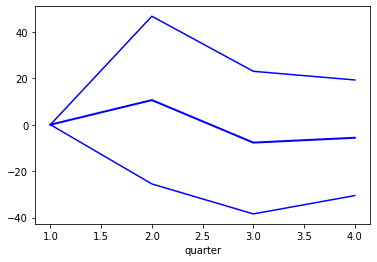

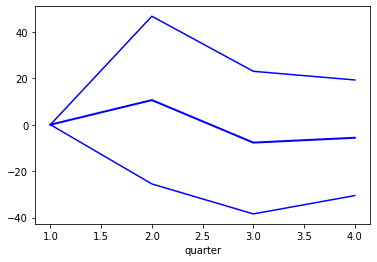

In [19]:
model1.plot_partial(1)

In [20]:
model1.fittedvalues

1949-01-01    121.620244
1949-02-01    106.618828
1949-03-01    129.927824
1949-04-01    119.557284
1949-05-01    117.690184
                 ...    
1957-08-01    440.779638
1957-09-01    407.426902
1957-10-01    362.817570
1957-11-01    322.389369
1957-12-01    324.087641
Freq: MS, Length: 108, dtype: float64

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


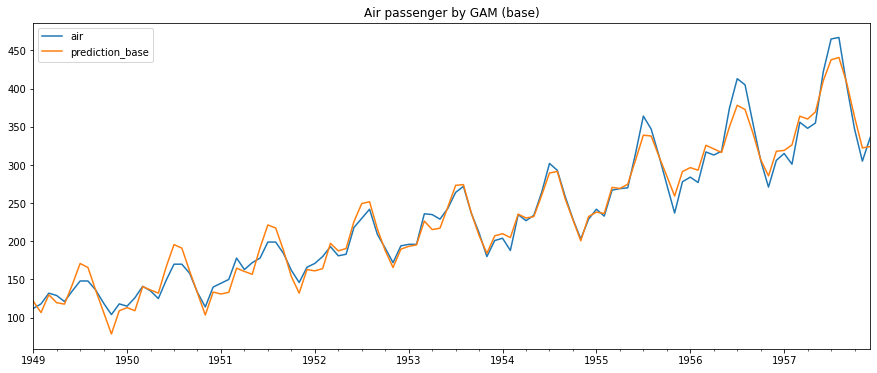

In [21]:
air_df_train['prediction_base'] = model1.fittedvalues

air_df_train[['air','prediction_base']].plot(figsize=(15,6))
plt.title('Air passenger by GAM (base)')
plt.show()

In [22]:
def mape(y_true,y_pred):
    y_true,y_pred = np.array(y_true), np.array(y_pred)
    return np.round(np.mean((np.abs(y_true-y_pred)/y_true))*100,2)

In [23]:
mape(air_df_train.air,air_df_train.prediction_base)

4.76

### Testing

In [24]:
predict_df = air_df_train[['month','quarter','t','year','weekday']]
# model1.predict(predict_df)

x_spline_t = bs.transform(air_df_test[['month','quarter','t']].values)

NotImplementedError: some data points fall outside the outermost knots, and I'm not sure how to handle them. (Patches accepted!)

*** *Above we can see that time variable 't' is out of scope in BSplines modeling because model has not learned for future data for the same* ***

### Model 2: Train

In [25]:
x_spline = air_df_train[['month','quarter','weekday']]
bs = BSplines(x_spline, df=[10 ,4,3], degree=[3,3,2])

base_model = GLMGam(air_df_train.air,exog=air_df_train[['year','t']],smoother=bs)

model2 = base_model.fit()

In [26]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    air   No. Observations:                  108
Model:                         GLMGam   Df Residuals:                    93.00
Model Family:                Gaussian   Df Model:                        14.00
Link Function:               identity   Scale:                          407.57
Method:                         PIRLS   Log-Likelihood:                -469.72
Date:                Thu, 19 May 2022   Deviance:                       37904.
Time:                        10:52:41   Pearson chi2:                 3.79e+04
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           0.0367      0.004      8.382      0.000       0.028       0.045
t              2.5006      0.063     39.750      0.000       2.377       2.624
month_s0     -76.3795     36.541     -2.090      0.037    -147.998      -4.761
month_s1      63.7225     35.763      1.782      0.075      -6.371     133.816
month_s2     -12.1390     39.792     -0.305      0.760     -90.130      65.852
month_s3       9.4918     33.523      0.283      0.777     -56.213      75.196
month_s4     113.2984     24.293      4.664      0.000      65.685     160.911
month_s5      37.4913     48.555      0.772      0.440     -57.675     132.657
month_s6     -14.7341     63.157     -0.233      0.816    -138.520     109.052
month_s7     -39.1756     40.642     -0.964      0.335    -118.832      40.481
month_s8       1.1818     17.657      0.067      0.947     -33.426      35.790
quarter_s0    39.3246     62.705      0.627      0.531     -83.575     162.224
quarter_s1   -36.6939     61.422     -0.597      0.550    -157.079      83.691
quarter_s2    -8.2752     17.111     -0.484      0.629     -41.812      25.261
weekday_s0     6.1552     10.789      0.570      0.568     -14.991      27.302
weekday_s1     5.7312      5.933      0.966      0.334      -5.897      17.359
==============================================================================
"""

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


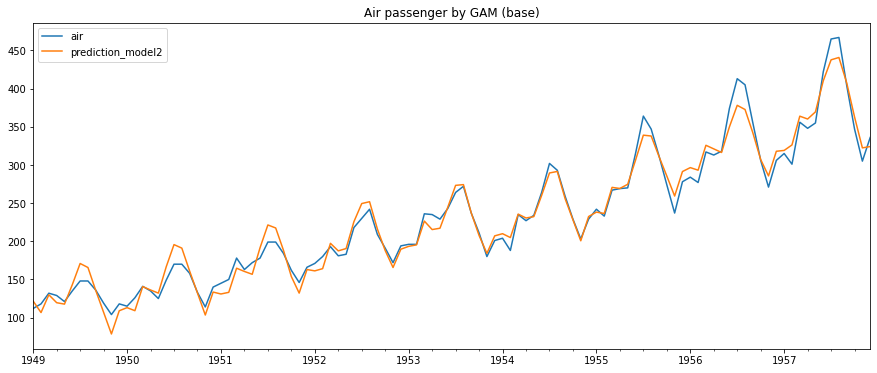

In [27]:
air_df_train['prediction_model2'] = model1.fittedvalues

air_df_train[['air','prediction_model2']].plot(figsize=(15,6))
plt.title('Air passenger by GAM (base)')
plt.show()

In [28]:
mape(air_df_train.air,air_df_train.prediction_model2)

4.76

### Testing

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


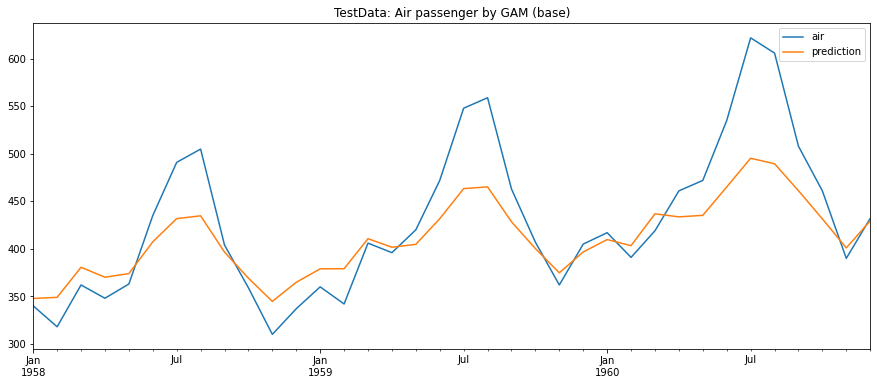

In [29]:
x_spline_t = bs.transform(air_df_test[['month','quarter','weekday']].values)

model2_prediction = model2.predict(air_df_test[['year','t']], air_df_test[['month','quarter','weekday']].values)

air_df_test["prediction"] = model2_prediction

air_df_test[['air','prediction']].plot(figsize=(15,6))
plt.title('TestData: Air passenger by GAM (base)')
plt.show()

In [30]:
mape(air_df_test.air,air_df_test.prediction)

7.09

***We can see that although mape in 7.09 however model is not able to pick trend in the data***

## Adding Moving averages

In [31]:
weights = [0.223744292,0.319634703,0.456621005]

air_df_train['air_3ma'] = air_df_train['air'].rolling(3).apply(lambda x: np.average(x,weights=weights))
air_df_train['air_lag'] = air_df_train['air'].shift(1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [32]:
air_df_train.head()

,air,time,t,lnair,year,week,month,quarter,weekday,year_half,prediction_base,prediction_model2,air_3ma,air_lag
1949-01-01,112,1949.000000,1.0,4.718499,1949,53,1,1,5,1,121.620244,121.620244,NaN,NaN
1949-02-01,118,1949.083374,2.0,4.770685,1949,5,2,1,1,1,106.618828,106.618828,NaN,112.0
1949-03-01,132,1949.166626,3.0,4.882802,1949,9,3,1,1,1,129.927824,129.927824,123.050228,118.0
1949-04-01,129,1949.250000,4.0,4.859812,1949,13,4,2,4,1,119.557284,119.557284,127.497717,132.0
1949-05-01,121,1949.333374,5.0,4.795791,1949,17,5,2,6,1,117.690184,117.690184,126.018265,129.0


In [33]:
### Def

def forward_predict(pred_df,train_df,com,train_model,exog_var,spline_var):
    train_l3 = train_df.tail(5)
    pred_df['air_3ma'] = np.nan
    pred_df['air'] = np.nan
    pred_df['air_lag'] = np.nan
    
    
    for x in range(0,len(pred_df)):
        if x==0:
            avg = train_l3.iloc[len(train_l3)-1]['air_3ma']*(0.223744292)+\
            train_l3.iloc[len(train_l3)-2]['air_3ma']*(0.319634703)+\
            train_l3.iloc[len(train_l3)-3]['air_3ma']*(0.456621005)
            print("Average:",avg)
            pred_df.iloc[x:x+1]['air_3ma']= avg
            pred_df.iloc[x:x+1]['air_lag']= train_l3.iloc[len(train_l3)-1]['air']
            print("air_3ma:",pred_df.iloc[x:x+1]['air_3ma'])
#             print("exog_df:",exog_df.iloc[x:x+1])
            
            prediction = train_model.predict(pred_df[exog_var].iloc[x:x+1],pred_df[spline_var].iloc[x:x+1].values)
            pred_df.iloc[x:x+1]['air'] = prediction
            train_l3 = train_l3.append(pred_df.iloc[x:x+1])
            
        else:
            avg = train_l3.iloc[len(train_l3)-1]['air_3ma']*(0.223744292)+\
            train_l3.iloc[len(train_l3)-2]['air_3ma']*(0.319634703)+\
            train_l3.iloc[len(train_l3)-3]['air_3ma']*(0.456621005)

            pred_df.iloc[x:x+1]['air_3ma']=avg
            pred_df.iloc[x:x+1]['air_lag']= train_l3.iloc[len(train_l3)-1]['air']
            prediction = train_model.predict(pred_df.iloc[x:x+1][exog_var],pred_df.iloc[x:x+1][spline_var].values)
            pred_df.iloc[x:x+1]['air'] = prediction
            train_l3 = train_l3.append(pred_df.iloc[x:x+1])
#             print(pred_df)
    return pred_df


def mape(y_true,y_pred):
    y_true,y_pred = np.array(y_true), np.array(y_pred)
    return np.round(np.mean((np.abs(y_true-y_pred)/y_true))*100,2)

In [34]:
air_df_train = air_df_train.dropna()
air_df_train.head()

,air,time,t,lnair,year,week,month,quarter,weekday,year_half,prediction_base,prediction_model2,air_3ma,air_lag
1949-03-01,132,1949.166626,3.0,4.882802,1949,9,3,1,1,1,129.927824,129.927824,123.050228,118.0
1949-04-01,129,1949.250000,4.0,4.859812,1949,13,4,2,4,1,119.557284,119.557284,127.497717,132.0
1949-05-01,121,1949.333374,5.0,4.795791,1949,17,5,2,6,1,117.690184,117.690184,126.018265,129.0
1949-06-01,135,1949.416626,6.0,4.905275,1949,22,6,2,2,1,143.164921,143.164921,129.182648,121.0
1949-07-01,148,1949.500000,7.0,4.997212,1949,26,7,3,4,2,170.925839,170.925839,137.803653,135.0


### Training

In [35]:
import statsmodels.api as sm
x_spline = air_df_train[['year_half','quarter','month']]
bs = BSplines(x_spline, df=[4,4,6,5], degree=[3,3,2,3])
cs = CyclicCubicSplines(x_spline, df=[3,3,5,5])
alpha = np.array([21833888.8, 6460.38479])
#family=sm.families.Gamma()
model = GLMGam(air_df_train.air,exog=air_df_train[['year','t','air_lag']],smoother=bs)

df_trans= bs.transform(air_df_train[['year_half','quarter','month','air_lag']].values)

pd.DataFrame(df_trans, columns=bs.col_names)

,year_half_s0,year_half_s1,year_half_s2,quarter_s0,quarter_s1,quarter_s2,month_s0,month_s1,month_s2,month_s3,month_s4
0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.666667,0.222222,0.000000,0.000000,0.000000
1,0.0,0.0,0.0,0.444444,0.222222,0.037037,0.500000,0.500000,0.000000,0.000000,0.000000
2,0.0,0.0,0.0,0.444444,0.222222,0.037037,0.222222,0.719807,0.057971,0.000000,0.000000
3,0.0,0.0,0.0,0.444444,0.222222,0.037037,0.055556,0.712560,0.231884,0.000000,0.000000
4,0.0,0.0,1.0,0.222222,0.444444,0.296296,0.000000,0.478261,0.521739,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
101,0.0,0.0,1.0,0.222222,0.444444,0.296296,0.000000,0.193676,0.733597,0.072727,0.000000
102,0.0,0.0,1.0,0.222222,0.444444,0.296296,0.000000,0.035573,0.673518,0.290909,0.000000
103,0.0,0.0,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.355556,0.632099,0.012346
104,0.0,0.0,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.088889,0.602469,0.308642


In [36]:
ma_model = model.fit()
ma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    air   No. Observations:                  106
Model:                         GLMGam   Df Residuals:                       95
Model Family:                Gaussian   Df Model:                        10.00
Link Function:               identity   Scale:                          174.11
Method:                         PIRLS   Log-Likelihood:                -418.06
Date:                Thu, 19 May 2022   Deviance:                       16540.
Time:                        10:53:14   Pearson chi2:                 1.65e+04
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
year             0.0078      0.003      2.277      0.023       0.001       0.014
t                0.6034      0.177      3.411      0.001       0.257       0.950
air_lag          0.7678      0.068     11.260      0.000       0.634       0.901
year_half_s0  1.746e-14   1.47e-14      1.190      0.234   -1.13e-14    4.62e-14
year_half_s1 -1.503e-14   2.48e-14     -0.607      0.544   -6.36e-14    3.35e-14
year_half_s2     3.8386      9.848      0.390      0.697     -15.463      23.140
quarter_s0    -110.0324     19.227     -5.723      0.000    -147.717     -72.348
quarter_s1     -50.7263      9.317     -5.444      0.000     -68.987     -32.465
quarter_s2     -14.6256     18.929     -0.773      0.440     -51.726      22.475
month_s0         3.4474      8.314      0.415      0.678     -12.849      19.743
month_s1       104.6269     14.983      6.983      0.000      75.262     133.992
month_s2        66.1299     18.533      3.568      0.000      29.806     102.453
month_s3       -55.3557     22.935     -2.414      0.016    -100.308     -10.403
month_s4        30.9338     19.024      1.626      0.104      -6.352      68.220
================================================================================
"""

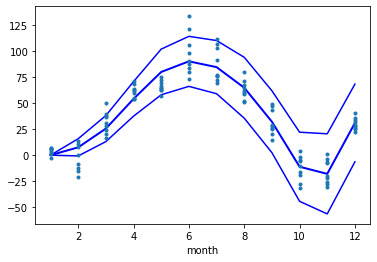

In [37]:
fig = ma_model.plot_partial(2, cpr=True)

In [38]:
ma_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: GLMGam
=================================================================
Model:                GLMGam           AIC:            858.1257  
Link Function:        identity         BIC:            16097.0314
Dependent Variable:   air              Log-Likelihood: -418.06   
Date:                 2022-05-19 10:53 LL-Null:        -2542.4   
No. Observations:     106              Deviance:       16540.    
Df Model:             9                Pearson chi2:   1.65e+04  
Df Residuals:         95               Scale:          174.11    
Method:               IRLS                                       
-----------------------------------------------------------------
               Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
-----------------------------------------------------------------
year            0.0078   0.0034  2.2771 0.0228    0.0011   0.0145
t               0.6034   0.1769  3.4108 0.0006    0.2566   0.9501
air_lag         0.7678   0.0682 11.2598 0.0000    0.6341   0.9014
year_half_s0    0.0000   0.0000  1.1902 0.2340   -0.0000   0.0000
year_half_s1   -0.0000   0.0000 -0.6069 0.5439   -0.0000   0.0000
year_half_s2    3.8386   9.8477  0.3898 0.6967  -15.4625  23.1398
quarter_s0   -110.0324  19.2271 -5.7228 0.0000 -147.7168 -72.3480
quarter_s1    -50.7263   9.3170 -5.4445 0.0000  -68.9874 -32.4652
quarter_s2    -14.6256  18.9291 -0.7727 0.4397  -51.7259  22.4748
month_s0        3.4474   8.3144  0.4146 0.6784  -12.8485  19.7434
month_s1      104.6269  14.9825  6.9833 0.0000   75.2618 133.9921
month_s2       66.1299  18.5328  3.5683 0.0004   29.8063 102.4534
month_s3      -55.3557  22.9354 -2.4136 0.0158 -100.3083 -10.4032
month_s4       30.9338  19.0238  1.6261 0.1039   -6.3521  68.2196
=================================================================

"""

In [39]:
np.exp(np.log(ma_model.aic))

858.1257159865594

In [40]:
ma_model.gcv

216.75940242183623

In [41]:
a = (ma_model.aic + ma_model.gcv)/2
a

537.4425592041978

In [42]:
np.log(a)

6.286821887694335

In [43]:
pen = model.select_penweight('aic')
# pen

In [44]:
(np.array([0.38422318, -0.43047247, -0.3848246]) + np.array([-10.55143118,  -7.74381638,  -7.59933367]))/2

array([-5.083604  , -4.08714442, -3.99207914])

In [45]:
a = np.exp([-10.55143118,  -7.74381638,  -7.59933367]).tolist()

In [46]:
model = GLMGam(air_df_train.air,exog=air_df_train[['year','t','air_lag']],smoother=cs,aplha=a)
ma_model = model.fit()
ma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    air   No. Observations:                  106
Model:                         GLMGam   Df Residuals:                    96.00
Model Family:                Gaussian   Df Model:                         9.00
Link Function:               identity   Scale:                          201.58
Method:                         PIRLS   Log-Likelihood:                -426.38
Date:                Thu, 19 May 2022   Deviance:                       19352.
Time:                        10:53:39   Pearson chi2:                 1.94e+04
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
year           -16.6911      7.287     -2.291      0.022     -30.973      -2.409
t                2.1139      0.588      3.596      0.000       0.962       3.266
air_lag          0.7206      0.073      9.928      0.000       0.578       0.863
year_half_s0  2.123e+04   9258.690      2.292      0.022    3078.599    3.94e+04
year_half_s1  2.989e-09    1.3e-09      2.292      0.022    4.34e-10    5.54e-09
year_half_s2 -6.137e-09   2.68e-09     -2.292      0.022   -1.14e-08    -8.9e-10
quarter_s0    7093.2777   3086.633      2.298      0.022    1043.589    1.31e+04
quarter_s1    7066.2708   3086.251      2.290      0.022    1017.329    1.31e+04
quarter_s2    7065.7498   3085.826      2.290      0.022    1017.642    1.31e+04
month_s0      4224.0883   1852.032      2.281      0.023     594.171    7854.005
month_s1      4250.5262   1854.316      2.292      0.022     616.133    7884.919
month_s2      4268.6095   1852.294      2.304      0.021     638.180    7899.039
month_s3      4284.9847   1851.313      2.315      0.021     656.478    7913.491
month_s4      4197.0896   1848.798      2.270      0.023     573.512    7820.667
================================================================================
"""

### Testing

In [47]:
df_test = air_df_test.drop(columns=['air'])
df_test.head()

,time,t,lnair,year,week,month,quarter,weekday,year_half,prediction
1958-01-01,1958.000000,109.0,5.828946,1958,1,1,1,2,1,347.771596
1958-02-01,1958.083374,110.0,5.762052,1958,5,2,1,5,1,348.987036
1958-03-01,1958.166626,111.0,5.891644,1958,9,3,1,5,1,380.593160
1958-04-01,1958.250000,112.0,5.852202,1958,14,4,2,1,1,370.146295
1958-05-01,1958.333374,113.0,5.894403,1958,18,5,2,3,1,373.944808


In [48]:
pred_df= forward_predict(df_test,air_df_train,0.1,ma_model,['year','t','air_lag'],['year_half','quarter','month'])

air_df_test['air_pred'] = pred_df['air']
air_df_test['air_3ma'] = pred_df['air_3ma']

pred_df.head()

Average: 361.39815683346137
air_3ma: 1958-01-01    361.398157
Freq: MS, Name: air_3ma, dtype: float64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

,time,t,lnair,year,week,month,quarter,weekday,year_half,prediction,air_3ma,air,air_lag
1958-01-01,1958.000000,109.0,5.828946,1958,1,1,1,2,1,347.771596,361.398157,334.089355,336.000000
1958-02-01,1958.083374,110.0,5.762052,1958,5,2,1,5,1,348.987036,341.391414,351.360765,334.089355
1958-03-01,1958.166626,111.0,5.891644,1958,9,3,1,5,1,380.593160,341.923751,374.634549,351.360765
1958-04-01,1958.250000,112.0,5.852202,1958,14,4,2,1,1,370.146295,350.646020,371.978866,374.634549
1958-05-01,1958.333374,113.0,5.894403,1958,18,5,2,3,1,373.944808,343.632233,380.419009,371.978866


Mape: 7.17
Test DF:


,air,time,t,lnair,year,week,month,quarter,weekday,year_half,prediction,air_pred,air_3ma
1958-01-01,340,1958.000000,109.0,5.828946,1958,1,1,1,2,1,347.771596,334.089355,361.398157
1958-02-01,318,1958.083374,110.0,5.762052,1958,5,2,1,5,1,348.987036,351.360765,341.391414
1958-03-01,362,1958.166626,111.0,5.891644,1958,9,3,1,5,1,380.593160,374.634549,341.923751
1958-04-01,348,1958.250000,112.0,5.852202,1958,14,4,2,1,1,370.146295,371.978866,350.646020
1958-05-01,363,1958.333374,113.0,5.894403,1958,18,5,2,3,1,373.944808,380.419009,343.632233


Train DF:


,air,time,t,lnair,year,week,month,quarter,weekday,year_half,prediction_base,prediction_model2,air_3ma,air_lag
1957-08-01,467,1957.583374,104.0,6.146329,1957,31,8,3,3,2,440.779638,440.779638,456.292237,465.0
1957-09-01,404,1957.666626,105.0,6.001415,1957,35,9,3,6,2,407.426902,407.426902,437.785388,467.0
1957-10-01,347,1957.750000,106.0,5.849325,1957,40,10,4,1,2,362.817570,362.817570,392.068493,404.0
1957-11-01,305,1957.833374,107.0,5.720312,1957,44,11,4,4,2,322.389369,322.389369,340.575342,347.0
1957-12-01,336,1957.916626,108.0,5.817111,1957,48,12,4,6,2,324.087641,324.087641,328.552511,305.0


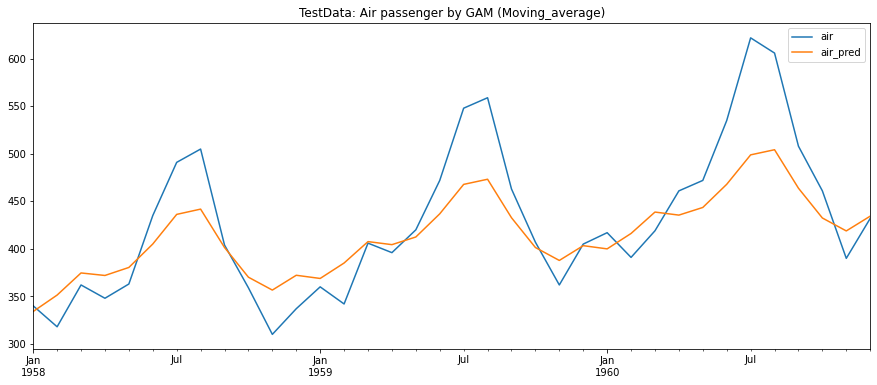

In [49]:
print('Mape:',mape(air_df_test['air'],air_df_test['air_pred']))
print("Test DF:")
display(air_df_test.head())
print("Train DF:")
display(air_df_train.tail())

air_df_test[['air','air_pred']].plot(figsize=(15,6))
plt.title('TestData: Air passenger by GAM (Moving_average)')
plt.show()

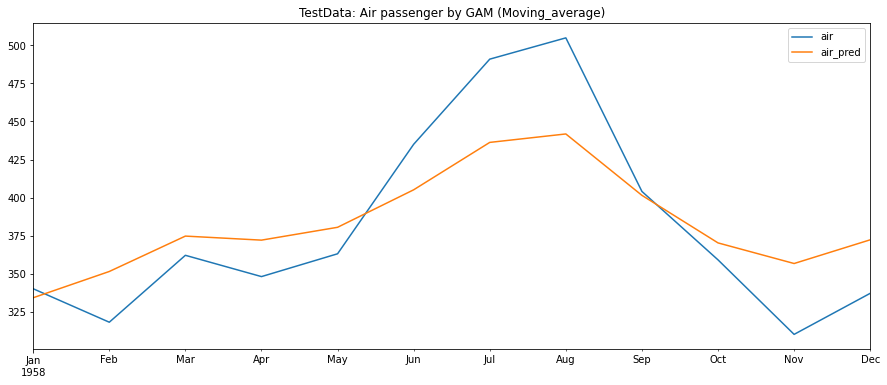

In [50]:
air_df_test[['air','air_pred']][air_df_test.index<'1959-01-01'].plot(figsize=(15,6))
plt.title('TestData: Air passenger by GAM (Moving_average)')
plt.show()